In [66]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = yf.download('AAPL','2008-01-01','2023-03-29')
new_data = yf.download('AAPL','2023-03-29')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


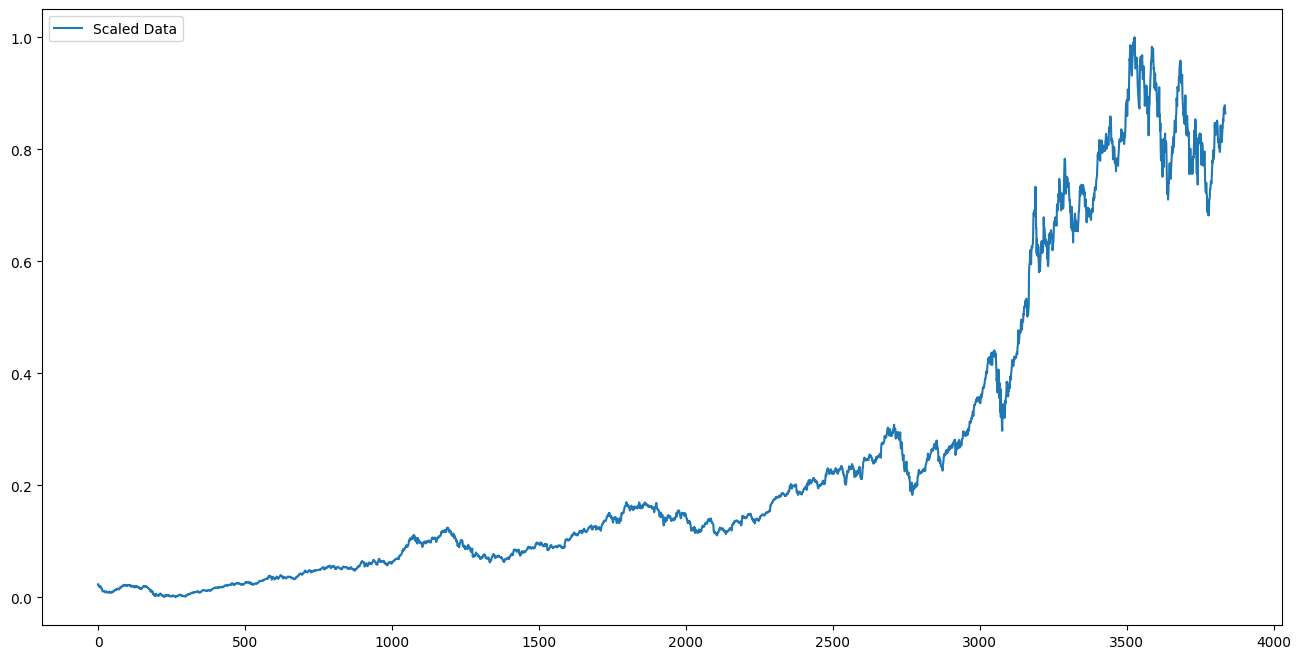

In [ ]:
#Scale the data and plot the scaled data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

#plot the scaled data from day 0 to current day
plt.figure(figsize=(16,8))
plt.plot(scaled_data, label='Scaled Data')
plt.legend(loc='upper left')
plt.show()

In [ ]:
scaled_data.shape

(3836, 1)

In [ ]:
print(scaled_data)

[[0.02324395]
 [0.02326189]
 [0.02029661]
 ...
 [0.87858307]
 [0.86759081]
 [0.8640755 ]]


In [ ]:
#Create a new dataframe with only the 'Close' column
data = data.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on (80% of the data)
training_size = int(np.ceil( len(scaled_data) * .8 ))
test_size = int(np.ceil( len(scaled_data) * .2 ))

#2860 is 80 percent of the total number of rows in the dataset
print("Total Rows in Training Dataset: ", training_size)
print("Total Rows in Testing Dataset: ", test_size)

Total Rows in Training Dataset:  3069
Total Rows in Testing Dataset:  768


In [ ]:
#Split the data in to training and testing data, 80% training and 20% testing starting from the beginning of the dataset
train_data = scaled_data[0:training_size , :]
test_data = scaled_data[training_size:len(scaled_data), :]

#remove null values
train_data = train_data[~np.isnan(train_data).any(axis=1)]
test_data = test_data[~np.isnan(test_data).any(axis=1)]

#print the shape of the training and testing data
print("Training Data Shape: ", train_data.shape)
print("Testing Data Shape: ", test_data.shape)

Training Data Shape:  (3069, 1)
Testing Data Shape:  (767, 1)


In [ ]:
#Time step is the number of days we want to look back to predict the next closing price
#We need use the training data to create the x_train and y_train data sets where x_train is the closing price of the previous 14 years and y_train is the closing price of the next day
#if data is 120, 130, 125, 140, 134, and 150 then x_train would be 120, 130, 125, 140, 134 and y_train would be 150
#We will do the same for the test data and then check the accuracy of the model

#Function to create the x_train and y_train data sets
def create_dataset (dataset, time_step=1):
    dataX, dataY = [], []
    #Loop through the data and create the x_train and y_train data sets
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] #Start from 0 to time_step and add to a
        dataX.append(a) #Store the values from 0 to time_step in dataX
        dataY.append(dataset[i+time_step, 0]) #Store the value of the next day in dataY
    return np.array(dataX), np.array(dataY) #Return the training data and the testing data as numpy arrays

In [ ]:
#time step is the number of days we want to look back to predict the next closing price and we will use 10 days for this model
time_step = 30

#Create the training data set
x_train, y_train = create_dataset(train_data, time_step)

#180 features and 2550 rows
print (x_train.shape) #the training data should have 10 features for 10 days
print (y_train.shape)

(3038, 30)
(3038,)


In [ ]:
time_step = 30

#Create the testing data set
x_test, y_test = create_dataset(test_data, time_step)

print(x_test.shape)
print(y_test.shape)

(736, 30)
(736,)


In [ ]:
print(x_test)

[[0.33068624 0.37217224 0.32228862 ... 0.35878065 0.36956368 0.36807107]
 [0.37217224 0.32228862 0.3371449  ... 0.36956368 0.36807107 0.37914702]
 [0.32228862 0.3371449  0.32851012 ... 0.36807107 0.37914702 0.37942603]
 ...
 [0.83210313 0.8262443  0.82702547 ... 0.86268054 0.87317064 0.86507991]
 [0.8262443  0.82702547 0.84287223 ... 0.87317064 0.86507991 0.87121766]
 [0.82702547 0.84287223 0.8392453  ... 0.86507991 0.87121766 0.87858307]]


In [ ]:
#Reshape the data to fit the LSTM model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
# Define the number of models to use in the ensemble
num_models = 5

# Define the input shape of your LSTM model
input_shape = (x_train.shape[1], 1)

# Create a list to store the models
models = []

# Train and save each model
for i in range(num_models):
    model = Sequential()
    #Add the first LSTM layer
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, verbose=0)
    models.append(model)
    

# Evaluate the models on the test set
y_preds = []
for model in models:
    y_pred = model.predict(x_test)
    y_preds.append(y_pred)

# Average the predictions
y_pred_ensemble = np.mean(y_preds, axis=0)

23/23 [==============================] - 2s 22ms/step


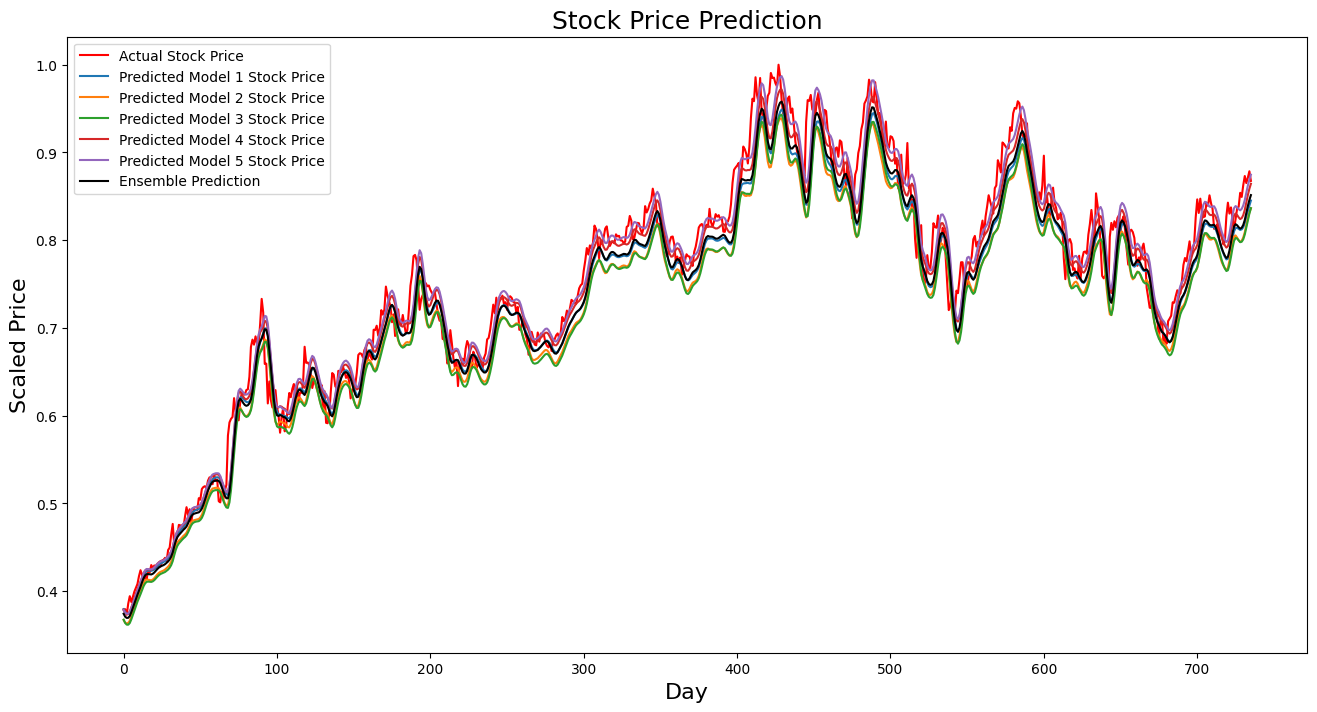

In [86]:
#plot all the models on the same graph
plt.figure(figsize=(16,8))
plt.plot(y_test, color='red', label='Actual Stock Price')
for i in range(num_models):
    plt.plot(y_preds[i], label='Predicted Model '+ str(i+1) + ' Stock Price')
plt.plot(y_pred_ensemble[:736], color='black', label='Ensemble Prediction')
plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Scaled Price', fontsize=16)
plt.legend()
plt.show()


95/95 [==============================] - 2s 19ms/step


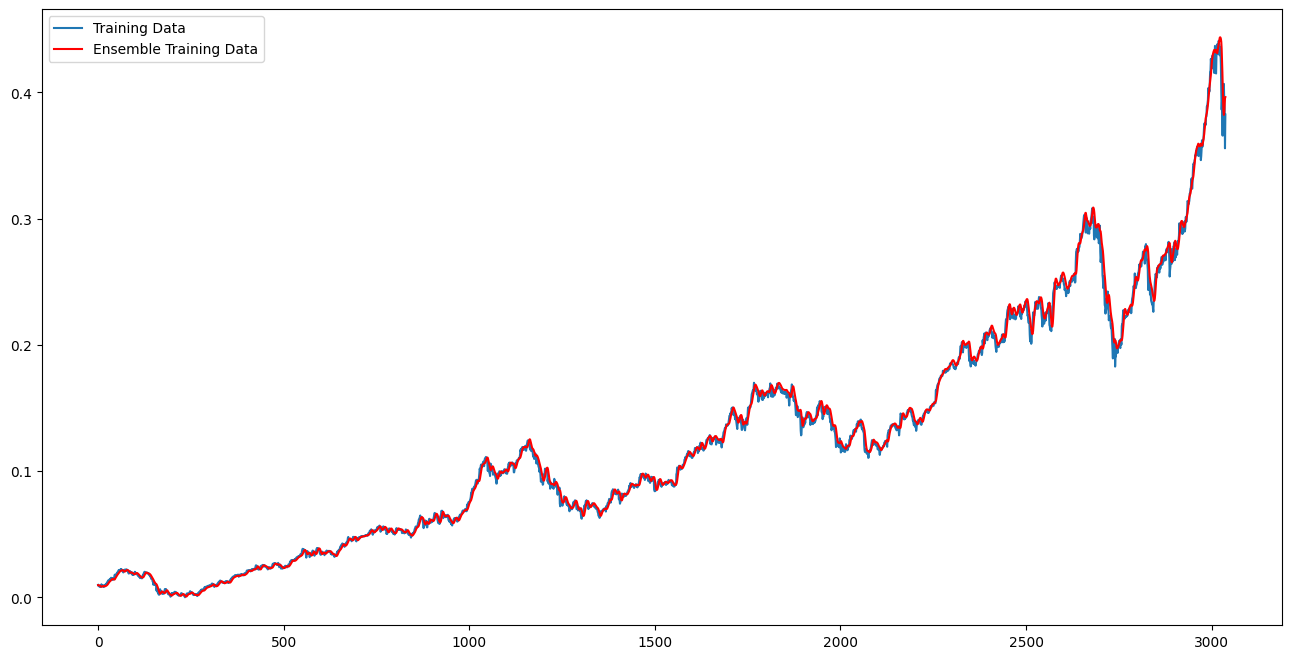

In [89]:
#plot the training data and ensemble training data
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Training Data')
plt.plot(model.predict(x_train), label='Ensemble Training Data', color='red')
plt.legend(loc='upper left')
plt.show()

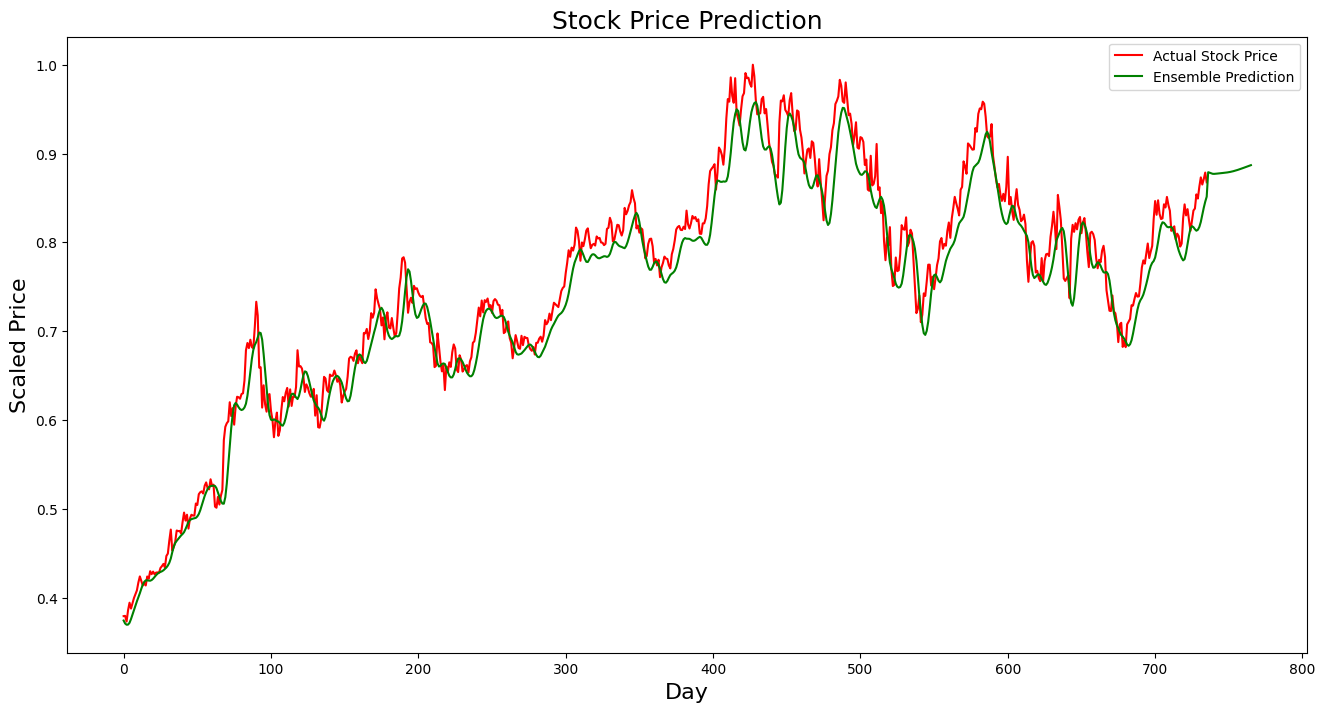

In [77]:
#PLOT the ensemble model and the actual stock price
plt.figure(figsize=(16,8))
plt.plot(y_test, color='red', label='Actual Stock Price')
plt.plot(y_pred_ensemble, color='green', label='Ensemble Prediction')
plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Scaled Price', fontsize=16)
plt.legend()
plt.show()


In [80]:
#calculate the MSE of the training data
mse_train = mean_squared_error(y_train, model.predict(x_train))
# Calculate the MSE of the ensemble
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble[:736])

#print the MSE of the training data and the ensemble
print("MSE of Training Data: ", mse_train)
print("MSE of Ensemble: ", mse_ensemble)

95/95 [==============================] - 2s 20ms/step
MSE of Training Data:  2.3106736957079392e-05
MSE of Ensemble:  0.0008706403594513345


In [ ]:
#Predict the next 30 days of stock price using the ensemble model
for i in range(30):
    x_test = np.append(x_test, y_pred_ensemble[-1])
    x_test = x_test[1:]
    x_test = x_test.reshape(1, x_test.shape[0], 1)
    y_pred_ensemble = np.append(y_pred_ensemble, model.predict(x_test))


1/1 [==============================] - 2s 2s/step


In [ ]:
print(y_pred_ensemble.shape)


(766,)


In [24]:
#print the predicted stock price for the next 30 days and convert the values back to the original scale
predictions_30 = scaler.inverse_transform(y_pred_ensemble.reshape(-1, 1))

print("Predicted Stock Price for the Next 30 Days: ", predictions_30[736:])

Predicted Stock Price for the Next 30 Days:  [[160.3278 ]
 [160.21362]
 [160.07874]
 [160.00072]
 [159.9825 ]
 [160.0023 ]
 [160.03813]
 [160.0761 ]
 [160.11043]
 [160.14091]
 [160.16988]
 [160.20042]
 [160.23526]
 [160.27646]
 [160.32518]
 [160.38213]
 [160.44728]
 [160.52045]
 [160.60109]
 [160.6885 ]
 [160.78186]
 [160.88026]
 [160.98279]
 [161.08853]
 [161.19655]
 [161.30595]
 [161.41594]
 [161.52574]
 [161.63475]
 [161.74231]]


In [31]:
print(predictions_30.shape)

(766, 1)


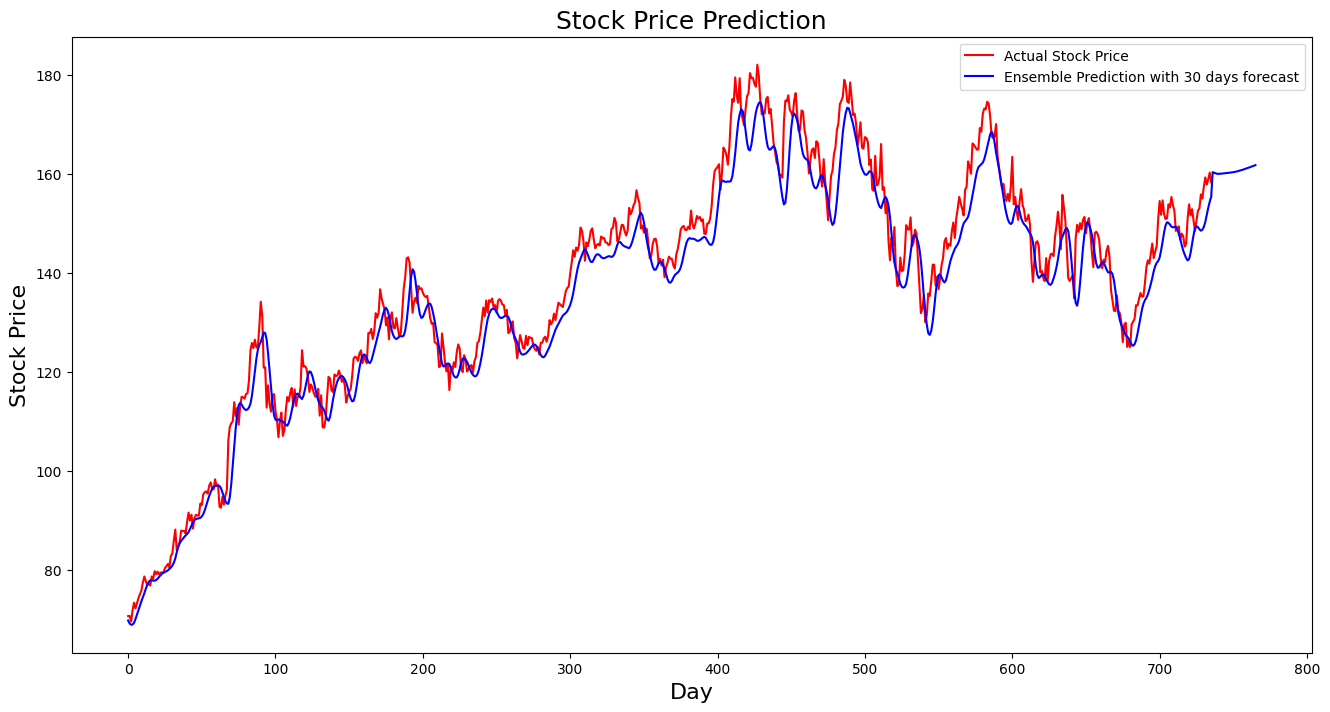

In [60]:
#Plot the predicted stock price for the next 30 days and the actual stock price
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), color='red', label='Actual Stock Price')
plt.plot(predictions_30, color='blue', label='Ensemble Prediction with 30 days forecast')
plt.title('Stock Price Prediction', fontsize=18)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
plt.legend()
plt.show()

In [34]:
new_data = yf.download('AAPL','2023-03-29')

[*********************100%***********************]  1 of 1 completed


In [35]:
#Create an array from date 2023-03-15 to 30 days in future 
future_dates = pd.date_range(start='2023-03-29', end='2023-05-09', freq='B')
#print(future_dates)

#convert it to an array
future_dates = future_dates.to_numpy()
print(future_dates)

future_dates.shape

['2023-03-29T00:00:00.000000000' '2023-03-30T00:00:00.000000000'
 '2023-03-31T00:00:00.000000000' '2023-04-03T00:00:00.000000000'
 '2023-04-04T00:00:00.000000000' '2023-04-05T00:00:00.000000000'
 '2023-04-06T00:00:00.000000000' '2023-04-07T00:00:00.000000000'
 '2023-04-10T00:00:00.000000000' '2023-04-11T00:00:00.000000000'
 '2023-04-12T00:00:00.000000000' '2023-04-13T00:00:00.000000000'
 '2023-04-14T00:00:00.000000000' '2023-04-17T00:00:00.000000000'
 '2023-04-18T00:00:00.000000000' '2023-04-19T00:00:00.000000000'
 '2023-04-20T00:00:00.000000000' '2023-04-21T00:00:00.000000000'
 '2023-04-24T00:00:00.000000000' '2023-04-25T00:00:00.000000000'
 '2023-04-26T00:00:00.000000000' '2023-04-27T00:00:00.000000000'
 '2023-04-28T00:00:00.000000000' '2023-05-01T00:00:00.000000000'
 '2023-05-02T00:00:00.000000000' '2023-05-03T00:00:00.000000000'
 '2023-05-04T00:00:00.000000000' '2023-05-05T00:00:00.000000000'
 '2023-05-08T00:00:00.000000000' '2023-05-09T00:00:00.000000000']


(30,)

In [36]:
#Create empty array of size 30
actual_thirtydays_values = np.empty((30,1))

#Fill the empty array with NaN values
actual_thirtydays_values[:] = np.nan

for i in range(0,30):
  try:
    actual_thirtydays_values[i] = new_data['Close'][i]
  except:
    actual_thirtydays_values[i] = np.nan
    

#Add the date and the actual values to the dataframe
actual_thirtydays_values = pd.DataFrame(actual_thirtydays_values, columns=['Close'])
actual_thirtydays_values['Date'] = future_dates
actual_thirtydays_values = actual_thirtydays_values.set_index('Date')

print (actual_thirtydays_values)

                 Close
Date                  
2023-03-29  160.770004
2023-03-30  162.360001
2023-03-31  164.899994
2023-04-03         NaN
2023-04-04         NaN
2023-04-05         NaN
2023-04-06         NaN
2023-04-07         NaN
2023-04-10         NaN
2023-04-11         NaN
2023-04-12         NaN
2023-04-13         NaN
2023-04-14         NaN
2023-04-17         NaN
2023-04-18         NaN
2023-04-19         NaN
2023-04-20         NaN
2023-04-21         NaN
2023-04-24         NaN
2023-04-25         NaN
2023-04-26         NaN
2023-04-27         NaN
2023-04-28         NaN
2023-05-01         NaN
2023-05-02         NaN
2023-05-03         NaN
2023-05-04         NaN
2023-05-05         NaN
2023-05-08         NaN
2023-05-09         NaN


In [37]:
#add the predicted closing price to the actual closing price
actual_thirtydays_values['Predictions'] = predictions_30[736:]

print(actual_thirtydays_values)

                 Close  Predictions
Date                               
2023-03-29  160.770004   160.327805
2023-03-30  162.360001   160.213623
2023-03-31  164.899994   160.078735
2023-04-03         NaN   160.000717
2023-04-04         NaN   159.982498
2023-04-05         NaN   160.002304
2023-04-06         NaN   160.038132
2023-04-07         NaN   160.076096
2023-04-10         NaN   160.110428
2023-04-11         NaN   160.140915
2023-04-12         NaN   160.169876
2023-04-13         NaN   160.200424
2023-04-14         NaN   160.235260
2023-04-17         NaN   160.276459
2023-04-18         NaN   160.325180
2023-04-19         NaN   160.382126
2023-04-20         NaN   160.447281
2023-04-21         NaN   160.520447
2023-04-24         NaN   160.601089
2023-04-25         NaN   160.688507
2023-04-26         NaN   160.781860
2023-04-27         NaN   160.880264
2023-04-28         NaN   160.982788
2023-05-01         NaN   161.088531
2023-05-02         NaN   161.196548
2023-05-03         NaN   161

In [57]:
#Calculate the accuracy from the actual closing price and the predicted closing price for the next 30 days

#calculate accuray by subtracting the actual closing price and the predicted closing price and divide by the actual closing price and multiply by 100 to get the percentage
accuracy = 100 - ( (actual_thirtydays_values['Close'] - actual_thirtydays_values['Predictions']) / actual_thirtydays_values['Close'] * 100)

#add the absolute accuracy to the actual closing price and the predicted closing price 
actual_thirtydays_values['Accuracy'] = accuracy

print (actual_thirtydays_values)


                 Close  Predictions   Accuracy Buy/Sell/Hold    Profit  \
Date                                                                     
2023-03-29  160.770004   160.327805  99.724949          Hold  2.677811   
2023-03-30  162.360001   160.213623  98.678013          Hold  2.563629   
2023-03-31  164.899994   160.078735  97.076253          Hold  2.428741   
2023-04-03         NaN   160.000717        NaN          Hold  2.350723   
2023-04-04         NaN   159.982498        NaN          Hold  2.332504   
2023-04-05         NaN   160.002304        NaN          Hold  2.352310   
2023-04-06         NaN   160.038132        NaN          Hold  2.388138   
2023-04-07         NaN   160.076096        NaN          Hold  2.426102   
2023-04-10         NaN   160.110428        NaN          Hold  2.460434   
2023-04-11         NaN   160.140915        NaN          Hold  2.490921   
2023-04-12         NaN   160.169876        NaN          Hold  2.519882   
2023-04-13         NaN   160.200424   

In [40]:
closingPrice = actual_thirtydays_values['Close']
print(closingPrice)

Date
2023-03-29    160.770004
2023-03-30    162.360001
2023-03-31    164.899994
2023-04-03           NaN
2023-04-04           NaN
2023-04-05           NaN
2023-04-06           NaN
2023-04-07           NaN
2023-04-10           NaN
2023-04-11           NaN
2023-04-12           NaN
2023-04-13           NaN
2023-04-14           NaN
2023-04-17           NaN
2023-04-18           NaN
2023-04-19           NaN
2023-04-20           NaN
2023-04-21           NaN
2023-04-24           NaN
2023-04-25           NaN
2023-04-26           NaN
2023-04-27           NaN
2023-04-28           NaN
2023-05-01           NaN
2023-05-02           NaN
2023-05-03           NaN
2023-05-04           NaN
2023-05-05           NaN
2023-05-08           NaN
2023-05-09           NaN
Name: Close, dtype: float64


In [45]:
#Add new column Buy/Sell/Hold to the dataframe with nil values
actual_thirtydays_values['Buy/Sell/Hold'] = 'NIL'

In [47]:
lastDay = data['Close'].iloc[-1]
print(lastDay)

157.64999389648438


In [48]:
firstPredicted = actual_thirtydays_values['Predictions'].iloc[0]
print(firstPredicted)

160.3278


In [49]:
difference = firstPredicted - lastDay
print(difference)

2.6778106689453125


In [50]:
print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold
Date                                                       
2023-03-29  160.770004   160.327805  0.275051           NIL
2023-03-30  162.360001   160.213623  1.321987           NIL
2023-03-31  164.899994   160.078735  2.923747           NIL
2023-04-03         NaN   160.000717       NaN           NIL
2023-04-04         NaN   159.982498       NaN           NIL
2023-04-05         NaN   160.002304       NaN           NIL
2023-04-06         NaN   160.038132       NaN           NIL
2023-04-07         NaN   160.076096       NaN           NIL
2023-04-10         NaN   160.110428       NaN           NIL
2023-04-11         NaN   160.140915       NaN           NIL


In [51]:
#ADD PROFIT COLUMN TO THE DATAFRAME
actual_thirtydays_values['Profit'] = np.nan
print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold  Profit
Date                                                               
2023-03-29  160.770004   160.327805  0.275051           NIL     NaN
2023-03-30  162.360001   160.213623  1.321987           NIL     NaN
2023-03-31  164.899994   160.078735  2.923747           NIL     NaN
2023-04-03         NaN   160.000717       NaN           NIL     NaN
2023-04-04         NaN   159.982498       NaN           NIL     NaN
2023-04-05         NaN   160.002304       NaN           NIL     NaN
2023-04-06         NaN   160.038132       NaN           NIL     NaN
2023-04-07         NaN   160.076096       NaN           NIL     NaN
2023-04-10         NaN   160.110428       NaN           NIL     NaN
2023-04-11         NaN   160.140915       NaN           NIL     NaN


In [52]:
total_difference  = difference
total_percentage = difference / lastDay * 100
print(total_difference)
print(total_percentage)

2.6778106689453125
1.6985796210709705


In [53]:
for i in range(0,29):
  if (i == 0):
    actual_thirtydays_values['Profit'][i] = total_difference
  else :
    total_difference  = total_difference + (actual_thirtydays_values['Predictions'][i] - actual_thirtydays_values['Predictions'][i-1])
    #print(total_difference)
    actual_thirtydays_values['Profit'][i] = total_difference

print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold    Profit
Date                                                                 
2023-03-29  160.770004   160.327805  0.275051           NIL  2.677811
2023-03-30  162.360001   160.213623  1.321987           NIL  2.563629
2023-03-31  164.899994   160.078735  2.923747           NIL  2.428741
2023-04-03         NaN   160.000717       NaN           NIL  2.350723
2023-04-04         NaN   159.982498       NaN           NIL  2.332504
2023-04-05         NaN   160.002304       NaN           NIL  2.352310
2023-04-06         NaN   160.038132       NaN           NIL  2.388138
2023-04-07         NaN   160.076096       NaN           NIL  2.426102
2023-04-10         NaN   160.110428       NaN           NIL  2.460434
2023-04-11         NaN   160.140915       NaN           NIL  2.490921


<ipython-input-53-94a5f0b61dab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Profit'][i] = total_difference
<ipython-input-53-94a5f0b61dab>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Profit'][i] = total_difference


In [54]:
#ADD PROFIT COLUMN TO THE DATAFRAME
actual_thirtydays_values['Profit %'] = 0.0
print(actual_thirtydays_values.head(10))

                 Close  Predictions  Accuracy Buy/Sell/Hold    Profit  \
Date                                                                    
2023-03-29  160.770004   160.327805  0.275051           NIL  2.677811   
2023-03-30  162.360001   160.213623  1.321987           NIL  2.563629   
2023-03-31  164.899994   160.078735  2.923747           NIL  2.428741   
2023-04-03         NaN   160.000717       NaN           NIL  2.350723   
2023-04-04         NaN   159.982498       NaN           NIL  2.332504   
2023-04-05         NaN   160.002304       NaN           NIL  2.352310   
2023-04-06         NaN   160.038132       NaN           NIL  2.388138   
2023-04-07         NaN   160.076096       NaN           NIL  2.426102   
2023-04-10         NaN   160.110428       NaN           NIL  2.460434   
2023-04-11         NaN   160.140915       NaN           NIL  2.490921   

            Profit %  
Date                  
2023-03-29       0.0  
2023-03-30       0.0  
2023-03-31       0.0  
2023-04-

In [58]:
#print(total_difference)
#print(total_percentage)
i=0
for i in range(0,29):
  if (i == 0):
    actual_thirtydays_values['Profit %'][i] = total_percentage
  else : 
    prediction_loss = (actual_thirtydays_values['Predictions'][i] - actual_thirtydays_values['Predictions'][i-1]) / (actual_thirtydays_values['Predictions'][i-1]) * 100
    #print(prediction_loss)
    total_percentage  = (total_percentage + prediction_loss ) 
    #print(total_percentage)
    actual_thirtydays_values['Profit %'][i] = total_percentage

  #Sell if the profit is less than 4% or the loss is greater than 2%
  if total_percentage > 4 or total_percentage < -2:
      #Calculate loss percentage 
      actual_thirtydays_values['Buy/Sell/Hold'][i] = "Sell"
  #hold if the profit is between -4% and 4%
  elif total_percentage >= -2 or total_percentage <= 4:
      actual_thirtydays_values['Buy/Sell/Hold'][i] = 'Hold'
  #Buy if the profit is greater than -4%
  elif total_percentage < -5:
      actual_thirtydays_values['Buy/Sell/Hold'][i] = 'Buy'

print(actual_thirtydays_values.head(10))


                 Close  Predictions   Accuracy Buy/Sell/Hold    Profit  \
Date                                                                     
2023-03-29  160.770004   160.327805  99.724949          Hold  2.677811   
2023-03-30  162.360001   160.213623  98.678013          Hold  2.563629   
2023-03-31  164.899994   160.078735  97.076253          Hold  2.428741   
2023-04-03         NaN   160.000717        NaN          Hold  2.350723   
2023-04-04         NaN   159.982498        NaN          Hold  2.332504   
2023-04-05         NaN   160.002304        NaN          Hold  2.352310   
2023-04-06         NaN   160.038132        NaN          Hold  2.388138   
2023-04-07         NaN   160.076096        NaN          Hold  2.426102   
2023-04-10         NaN   160.110428        NaN          Hold  2.460434   
2023-04-11         NaN   160.140915        NaN          Hold  2.490921   

            Profit %  
Date                  
2023-03-29  2.510788  
2023-03-30  2.439570  
2023-03-31  2.35537

<ipython-input-58-53b8ba31e85b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Profit %'][i] = total_percentage
<ipython-input-58-53b8ba31e85b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Buy/Sell/Hold'][i] = 'Hold'
<ipython-input-58-53b8ba31e85b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_thirtydays_values['Profit %'][i] = total_percentage
